 ### Test NodeSpecGen() and CodeSnippetGen() for `filter.median`

In [87]:

# input information:
op_name = "filter.median"
type_mapping_table_file = 'mapping_common_input_java_types_full.xlsx'

node_spec_generator = NodeSpecGeneration(ij, op_name, type_mapping_table_file)
node_spec_generator.run()

Your ImageJ Op [filter_median] has been converted to a visual node. 
You may add `filter_median_20240411133109.json` to the Node Extension Manager in the sidebar and use it in the menu.


--- Ori 3d Image Information ---
 type: <class 'numpy.ndarray'>
dtype: uint16
shape: (60, 2, 256, 256)
--------------------------------
------ Image After slicing ------
 image slice in channel [1] and Z [35]


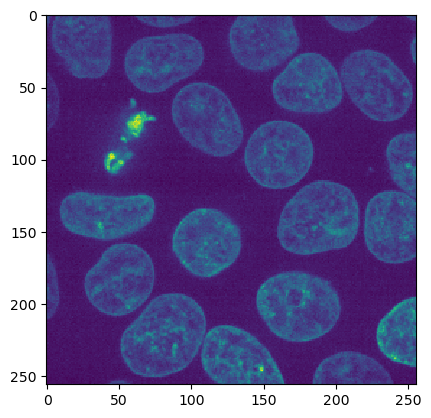

 type: <class 'numpy.ndarray'>
dtype: uint8
shape: (256, 256)
--------------------------------
--- After Edge Preserve Smoothing ---


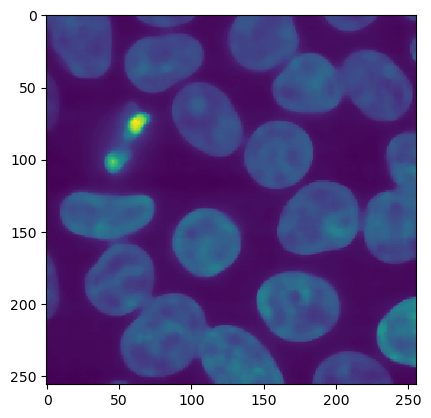

 type: <class 'numpy.ndarray'>
dtype: uint8
shape: (256, 256)
--------------------------------


In [88]:
{"nodes":[{"id":"0","type":"Flow Control.main","position":{"x":163.20172119140625,"y":88.258544921875},"outputs":{"execOut":{"dataType":"exec"}},"title":"main"},{"id":"1","type":"cell_segmentation_s6_e7_o1_m3_fillHole1.3d_image_slicing","position":{"x":264.20172119140625,"y":56.258544921875},"inputs":{"execIn":{"title":"execIn","dataType":"exec"},"path":{"title":"path","value":"test_cells3d.tif","dataType":"string"},"channelIndex":{"title":"channelIndex","dataType":"integer"},"z/tIndex":{"title":"z/tIndex","dataType":"integer"}},"outputs":{"execOut":{"title":"execOut","dataType":"exec"},"image":{"title":"image","dataType":"image"}},"title":"3d_image_slicing"},{"id":"2","type":"filter_median_20240411133109.filter_median","position":{"x":611.5271764436304,"y":58.43717077550764},"inputs":{"execIn":{"title":"execIn","dataType":"exec"},"input_image":{"title":"process_image","value":{"dataType":"numpy.ndarray","metadata":[{"colorChannel":"grayscale","isMiniBatched":false,"channelOrder":"channelLast","intensityRange":["0-255"],"device":["cpu"]}]},"dataType":"image"},"HyperSphereShape(range)":{"title":"HyperSphereShape(range)","value":5,"dataType":"integer"}},"outputs":{"execOut":{"title":"execOut","dataType":"exec"},"output_image":{"title":"image","dataType":"image"}},"title":"filter_median"}],"edges":[{"id":"reactflow__edge-0execOut-1execIn","output":"0","input":"1","outputHandle":"execOut","inputHandle":"execIn","dataType":"exec","style":{"strokeWidth":2,"stroke":"hsl(0, 0%, 0%)"}},{"id":"reactflow__edge-1execOut-2execIn","output":"1","input":"2","outputHandle":"execOut","inputHandle":"execIn","dataType":"exec","style":{"strokeWidth":2,"stroke":"hsl(0, 0%, 0%)"}},{"id":"reactflow__edge-1image-2input_image","output":"1","input":"2","outputHandle":"image","inputHandle":"input_image","dataType":"image","style":{"strokeWidth":2,"stroke":"hsl(300, 200%, 25%)"}}]}

### Class : Code Snippet Generator

In [11]:
import textwrap
class CodeSnippetGenerator:
    def __init__(self, op_name, mapping_dict):
        self.op_name = op_name
        self.mapping_dict = mapping_dict
        self.code_snippets = self.generate_code_snippets() 
        
    def import_part(self):
        return "import imagej\nimport scyjava as sj\nij = imagej.init('sc.fiji:fiji:2.14.0')\n"

    def get_input_image(self):
        return "#Get input image\nvp_input_image = n_1_image\nprocess_image = vp_input_image.get('value')\n"
    
    def get_op_name(self,op_name):
        return f"Op_name = '{op_name}'\n"
                     
    def is_empty_result_image_required(self,opInfo):
        for input in opInfo.inputs():
            if input.isOutput() and input.isRequired():
                return True
        return False
        
    def prepare_empty_result_image(self):
        return "jimage = ij.py.to_java(process_image)\nresult_image = ij.op().run('create.img',jimage)\n"
    
    def get_op_infos(self,op_name):
        ops = ij.op()
        all_infos = ops.infos()
        op_infos = [info for info in all_infos if info.getName() == op_name]
        return op_infos
    
    def get_op_required_parameters(self,opInfo):
        para_dict = {}
        for input in opInfo.inputs():
            if input.isRequired():
                current_input_type = str(input.getType())
                # Remove 'interface ' or 'class ' prefix from the type string
                if current_input_type.startswith('interface '):
                    current_input_type = current_input_type[len('interface '):]
                elif current_input_type.startswith('class '):
                    current_input_type = current_input_type[len('class '):]
                para_dict[input.getName()] = current_input_type
        return para_dict
        
    def get_short_classname(self,full_classname):
         return full_classname.split('.')[-1]
        
    def import_java_class_by_jimport(self,op_parameters, mapping_dict):
        import_statements = ''
        for key, value in op_parameters.items():
            if value in mapping_dict and mapping_dict[value]['jimport'] not in {None, 'None'}:
                short_classname = self.get_short_classname(mapping_dict[value]['jimport'])
                import_statements += f'{short_classname} = sj.jimport("{mapping_dict[value]["jimport"]}")\n'
        return import_statements
    
    def op_calling_and_running(self,opInfo, mapping_dict):                   
        code = 'result_image= ij.op().run(Op_name, ij.py.jargs('
        args = []
        for input in opInfo.inputs():
            if not input.isRequired():
                args.append('None')
                continue
                
            current_input_type = str(input.getType())
            if current_input_type.startswith('interface '):
                current_input_type = current_input_type[len('interface '):]
            elif current_input_type.startswith('class '):
                current_input_type = current_input_type[len('class '):]
    
            if current_input_type in mapping_dict:
                if mapping_dict[current_input_type]['specific_usage'] not in {None, 'None'}:
                    args.append(mapping_dict[current_input_type]['specific_usage'])
                else:
                    if mapping_dict[current_input_type]['parameter'] not in {None, 'None'}:
                        args.append(mapping_dict[current_input_type]['parameter'])
                        
            # Check if the input is an output and is required
            if input.isOutput() and input.isRequired():
                # Change the current argument to 'result_image'
                args[-1] = 'result_image'
    
        # Join the arguments with ', ' and add them to the function call
        code += ', '.join(args) + '))\n'
        return code

    def type_conversion(self):
        return 'result_image = ij.py.from_java(result_image)\n'

    
    def normalization_for_PIL_image(self):
        return 'result_image = ((result_image - result_image.min()) / (result_image.max() - result_image.min())* 255).astype(\'uint8\')\n'
    
    def display_image_information(self):
        return textwrap.dedent('''\
            def image_info(image):
                print("--- After Edge Preserve Smoothing ---")
                ij.py.show(image)
                print(f" type: {type(image)}")
                print(f"dtype: {image.dtype if hasattr(image, 'dtype') else 'N/A'}")
                print(f"shape: {image.shape}")
                print ("--------------------------------")
            image_info(result_image);
        ''')

    def add_metadata_for_output(self):
        return textwrap.dedent('''\
            result_image = {
              'value': result_image,
              'dataType': 'numpy.ndarray',
              'metadata': {
                'colorChannel': 'grayscale',
                'channelOrder': 'channelLast',
                'isMiniBatched': False,
                'intensityRange': '0-255',
                'device': 'cpu'
              }
            }
        ''')

    def generate_code_snippets(self):
        """
        Generate a code snippet for the given operation name and mapping dictionary.
        
        Parameters:
        op_name (str): The name of the operation.
        mapping_dict (dict): The mapping dictionary.
    
        Returns:
        str: The generated code snippet.
        """

        op_infos = self.get_op_infos(self.op_name)
        code_snippets = []
        for op_info in op_infos:
            required_parameters = self.get_op_required_parameters(op_info)
    
            code_snippet = self.import_part()
            code_snippet += self.get_input_image()
            code_snippet += self.get_op_name(self.op_name)
            code_snippet += self.import_java_class_by_jimport(required_parameters, self.mapping_dict)
    
            if self.is_empty_result_image_required(op_info):
                code_snippet += self.prepare_empty_result_image()
                
            code_snippet += self.op_calling_and_running(op_info, self.mapping_dict)
            code_snippet += self.type_conversion()
            code_snippet += self.normalization_for_PIL_image()
            code_snippet += self.display_image_information()
            code_snippet += self.add_metadata_for_output()
            code_snippets.append(code_snippet)
        
        return code_snippets
        
    def __str__(self):
        return "\n".join(self.code_snippets)


In [7]:
import imagej
import scyjava as sj
ij = imagej.init('sc.fiji:fiji:2.14.0')

In [12]:
import pandas as pd
def mapping_xlsx_to_mapping_dict(file_path):
    df = pd.read_excel(file_path,index_col = 0)
    data_dict = df.to_dict('index')
    return data_dict
code_snippet_generator = CodeSnippetGenerator("threshold.otsu", mapping_xlsx_to_mapping_dict('mapping_common_input_java_types_full.xlsx'))
print(code_snippet_generator)

import imagej
import scyjava as sj
ij = imagej.init('sc.fiji:fiji:2.14.0')
#Get input image
vp_input_image = n_1_image
process_image = vp_input_image.get('value')
Op_name = 'threshold.otsu'
result_image= ij.op().run(Op_name, ij.py.jargs(None, process_image))
result_image = ij.py.from_java(result_image)
result_image = ((result_image - result_image.min()) / (result_image.max() - result_image.min())* 255).astype('uint8')
def image_info(image):
    print("--- After Edge Preserve Smoothing ---")
    ij.py.show(image)
    print(f" type: {type(image)}")
    print(f"dtype: {image.dtype if hasattr(image, 'dtype') else 'N/A'}")
    print(f"shape: {image.shape}")
    print ("--------------------------------")
image_info(result_image);
result_image = {
  'value': result_image,
  'dataType': 'numpy.ndarray',
  'metadata': {
    'colorChannel': 'grayscale',
    'channelOrder': 'channelLast',
    'isMiniBatched': False,
    'intensityRange': '0-255',
    'device': 'cpu'
  }
}

import imagej
import sc

In [13]:
ij.op().help("threshold.otsu")

'Available operations:
	(RealType out?) =
	net.imagej.ops.threshold.otsu.ComputeOtsuThreshold(
		RealType out?,
		Histogram1d in)
	(IterableInterval out?) =
	net.imagej.ops.threshold.ApplyThresholdMethod$Otsu(
		IterableInterval out?,
		IterableInterval in)
	(IterableInterval out) =
	net.imagej.ops.threshold.ApplyThresholdMethodLocal$LocalOtsuThreshold(
		IterableInterval out,
		RandomAccessibleInterval in,
		Shape shape,
		OutOfBoundsFactory outOfBoundsFactory?)'

### Class : Node specification generation

In [1]:
import copy
import ast
import astor
import pandas as pd
import imagej
import scyjava as sj
import numpy as np
import json
from datetime import datetime
ij = imagej.init('sc.fiji:fiji:2.14.0')

In [84]:
class NodeSpecGeneration:
    
    def __init__(self, ij, op_name, type_mapping_table_file):
            self.ij = ij
            self.op_name = op_name
            self.type_mapping_table_file = type_mapping_table_file
            mapping_dict = self.mapping_xlsx_to_mapping_dict(self.type_mapping_table_file)
            self.type_mapping_table_file = type_mapping_table_file
            self.code_snippet = CodeSnippetGenerator(self.op_name, mapping_dict).code_snippet
        
    def get_node_json_template(self):
        node_json_template = {
            "description": "This is package description",
            "enable": True,
            "nodes": {
                "Op_name": {
                    "type": "Op_name",
                    "category": "function",
                    "title": "Op_name",
                    "tooltip": "This is node tooltip",
                    "externalImports": " ",
                    "codeGenerator": "function code(inputs, outputs, node, generator) {\n  const code = ` `\n;\n  return code;\n}",
                    "inputs": {
                        "execIn": {
                            "title": "execIn",
                            "tooltip": "execIn",
                            "dataType": "exec",
                            "showWidget": False,
                            "showTitle": False
                        },
                        "input_image": {
                            "title": "image",
                            "dataType": "image",
                            "defaultValue": {
                                "dataType": "numpy.ndarray",
                                "metadata": [
                                    {
                                        "colorChannel": "grayscale",
                                        "isMiniBatched": False,
                                        "channelOrder": "channelLast",
                                        "intensityRange": [
                                            "0-255"
                                        ],
                                        "device": [
                                            "cpu"
                                        ]
                                    }
                                ]
                            },
                            "tooltip": "input image."
                        },
                    },
                    "outputs": {
                        "execOut": {
                            "title": "execOut",
                            "tooltip": "execOut",
                            "dataType": "exec",
                            "showWidget": False,
                            "showTitle": False
                        },
                        "output_image": {
                            "title": "image",
                            "dataType": "image",
                            "defaultValue": {
                                "dataType": "numpy.ndarray"
                            },
                            "tooltip": "{dataType: numpy.ndarray, value, layout: [chw], colorMode: [rgb, grayscale], intensityRange: 0-255' device: cpu}"
                        }
                    }
                }
            }
        }
        return node_json_template

    def update_op_name(self, op_name, node_json_template):
        self.op_name = op_name.replace('.', '_')
        updated_json = copy.deepcopy(node_json_template)
        if 'Op_name' in updated_json['nodes']:
            # Update the 'Op_name' in the copied JSON
            updated_json['nodes'][self.op_name] = updated_json['nodes'].pop('Op_name')
            # Update the 'type' and 'title' fields
            updated_json['nodes'][self.op_name]['type'] = self.op_name
            updated_json['nodes'][self.op_name]['title'] = self.op_name
        else:
            print("There's no Op_name in your node_template, please check again")
        return updated_json

    def extract_and_remove_imports(self, code_snippet):
        parsed_code = ast.parse(code_snippet)
        imports = []
        for node in parsed_code.body:
            if isinstance(node, ast.Import):
                for alias in node.names:
                    name = alias.name
                    asname = ' as ' + alias.asname if alias.asname else ''
                    imports.append(f"import {name}{asname}")
            elif isinstance(node, ast.Assign) and 'imagej' in [imp.split()[1] for imp in imports]:
                if isinstance(node.targets[0], ast.Name) and node.targets[0].id == 'ij':
                    if isinstance(node.value, ast.Call) and node.value.func.attr == 'init':
                        imports.append(astor.to_source(node).strip())
        # Remove the extracted imports from the original code snippet
        for import_statement in imports:
            code_snippet = code_snippet.replace(import_statement, '', 1)
        return imports, code_snippet.strip()

    def update_external_imports(self, node_json_template, op_name, extracted_imports):
        updated_json = copy.deepcopy(node_json_template)      
        if op_name in updated_json['nodes']:
            updated_imports = '\n'.join(extracted_imports)
            updated_json['nodes'][op_name]['externalImports'] = updated_imports
        else:
            print(f"There's no {op_name} in your node_template, please check again")
        return updated_json

    def get_format_parameters(self,opInfo,mapping_dict):
        needed_input_name = ["n_1_image"]
        needed_output_name = "result_image"
        for input in opInfo.inputs():
            current_input_type = str(input.getType())
            if current_input_type.startswith('interface '):
                current_input_type = current_input_type[len('interface '):]
            elif current_input_type.startswith('class '):
                current_input_type = current_input_type[len('class '):]
    
            if current_input_type in mapping_dict:
                if mapping_dict[current_input_type]['parameter'] not in {None, 'None','process_image'}:
                    needed_input_name.append(mapping_dict[current_input_type]['parameter'])  
        return needed_output_name, needed_input_name    
        
    def format_code_with_unknown_input_number(self, code, output1, *args):
        code_copy = code[:]
        # Replace the output name in the code
        code_copy = code_copy.replace(output1, "${outputs[1]}")
        # Replace the input names in the code
        for i, arg in enumerate(args, start=1):
            code_copy = code_copy.replace(arg, f"${{inputs[{i}]}}")
        # Add a visible '\n' at the end of each line
        code_copy = '\\n'.join(code_copy.strip().splitlines()) + '\\n'
        code_copy += '${outputs[0]}'
        # Add backticks at the beginning and end of the code
        code_copy = '`' + code_copy + '`'  
        codeGenerator = f"""function code(inputs, outputs, node, generator) {{
          const code = {code_copy};
          return code;
        }}"""
        return codeGenerator

    def update_code_generator(self, node_json_template, op_name, extracted_code_generator):
        updated_json = copy.deepcopy(node_json_template)
        if op_name in updated_json['nodes']:
            # Update the 'externalImports' field in the node
            updated_json['nodes'][op_name]['codeGenerator'] = extracted_code_generator
        else:
            print(f"There's no {op_name} in your node_template, please check again")
        return updated_json

    def extract_op_parameter(self, code_snippet):
        class CallVisitor(ast.NodeVisitor):
            def __init__(self):
                self.jargs_args = []
    
            def visit_Call(self, node):
                # Check if the function being called is 'ij.op().run'
                if isinstance(node.func, ast.Attribute) and node.func.attr == 'run':
                    # Check if the second argument is a call to 'ij.py.jargs'
                    if isinstance(node.args[1], ast.Call) and node.args[1].func.attr == 'jargs':
                        # Extract the arguments of 'ij.py.jargs'
                        self.jargs_args.extend([astor.to_source(arg).strip() for arg in node.args[1].args])
                self.generic_visit(node)
        visitor = CallVisitor()
        tree = ast.parse(code_snippet)
        visitor.visit(tree)
        return visitor.jargs_args

    def get_matching_op(self, ij, op_name, extracted_op_parameter):
        num_params =len(extracted_op_parameter)
        infos = ij.op().infos()
        for info in infos:
            # Check if the operation name matches
            if info.getName() == op_name:
                # Get the list of inputs
                inputs = info.inputs()
                # Count the number of all inputs (required or optional)
                count = sum(1 for input in inputs)
                if count == num_params:
                    # Return the matching operation
                     return info
        return None

    def get_input_java_type(self, ij, opInfo):
        input_java_types = []
        for i, input in enumerate(opInfo.inputs()):  # Iterate over the inputs
            input_java_type  = str(input.getType())
            # Remove 'interface ' and 'class ' substrings
            input_java_type = input_java_type.replace('interface ', '').replace('class ', '')
            input_java_types.append(input_java_type)
        return input_java_types

    def mapping_xlsx_to_mapping_dict(self, file_path):
        df = pd.read_excel(file_path,index_col = 0)
        data_dict = df.to_dict('index')
        return data_dict

    def java_type_to_vp_datatype(self, input_java_types, mapping_dict):
        datatypes = []  
        for java_type in input_java_types:  
            # Get the datatype from the dictionary, if it's not found, use 'any'
            datatype = mapping_dict.get(java_type, {'datatype': 'any'})['datatype']
            datatypes.append(datatype)  
        return datatypes  

    def update_inputs_info(self,node_json_template, matching_op, extracted_op_parameter, mapping_dict):
        updated_json = copy.deepcopy(node_json_template)
        extracted_op_parameter_copy = list(extracted_op_parameter)
        # Iterate over matching_op.inputs()
        for i, input in enumerate(matching_op.inputs()):
            # Check if the input is actually an output
            if input.isOutput():
                continue  # Skip to the next iteration
            # Get the Java type of the input
            input_java_type = str(input.getType()).replace('interface ', '').replace('class ', '')
            # Map the Java type to your custom data type
            datatype = self.java_type_to_vp_datatype([input_java_type], mapping_dict)[0]
            # Get the parameter from extract_op_parameters
            param = extracted_op_parameter_copy[i]
            # Check if the parameter is 'None'
            if param == 'None':
                continue  # Skip to the next iteration
            # Check if the dataType is 'image'
            if datatype == 'image':
                # Update the title of the 'input_image' item
                updated_json['nodes'][self.op_name]['inputs']['input_image']['title'] = param
            else:
                # Add a new item to the inputs in the JSON template for each remaining item in extract_op_parameters
                updated_json['nodes'][self.op_name]['inputs'][param] = {
                    "title": param,
                    "dataType": datatype,
                    "tooltip": f"This is {param} tooltip"
                }
        return updated_json


    def output_json(self, updated_json):
        timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
        filename = f"{self.op_name}_{timestamp}.json"
        with open(filename, 'w') as f:
            json.dump(updated_json, f, indent=4)
        print(f"Your ImageJ Op [{self.op_name}] has been converted to a visual node. \nYou may add `{filename}` to the Node Extension Manager in the sidebar and use it in the menu.")
    
    def print_json(self,json_data):
        print(json.dumps(json_data, indent=4))

    def print_mapping_dict(self,mapping_dict):
        import pprint
        pp = pprint.PrettyPrinter(indent=4)
        pp.pprint(mapping_dict)
    
    def run(self):
        node_json_template = self.get_node_json_template()
        updated_json = self.update_op_name(self.op_name, node_json_template)
        extracted_imports, code_snippet_without_imports = self.extract_and_remove_imports(self.code_snippet)
        updated_json = self.update_external_imports(updated_json, self.op_name, extracted_imports)
        extracted_op_parameter = self.extract_op_parameter(code_snippet_without_imports)
        matching_op = self.get_matching_op(ij, self.op_name.replace('_', '.'), extracted_op_parameter)
        input_java_types = self.get_input_java_type(ij, matching_op)
        mapping_dict = self.mapping_xlsx_to_mapping_dict(self.type_mapping_table_file)
        datatypes = self.java_type_to_vp_datatype(input_java_types, mapping_dict)
        updated_json= self.update_inputs_info(updated_json, matching_op, extracted_op_parameter, mapping_dict)
        self.needed_output_name, self.needed_input_name = self.get_format_parameters(matching_op, mapping_dict)
        formated_code_for_codeGenerator = self.format_code_with_unknown_input_number(code_snippet_without_imports, self.needed_output_name, *self.needed_input_name)
        updated_json = self.update_code_generator(updated_json, self.op_name, formated_code_for_codeGenerator)
       
        self.output_json(updated_json)
